
=== XGBoost - V1_Baseline ===

XGBoost (V1_Baseline) - Run 1
Accuracy: 0.8302
Precision: 0.2414
Recall: 0.0543
F1 Score: 0.0886
ROC AUC: 0.6393
Cross-Validation F1: 0.1614 ± 0.0318


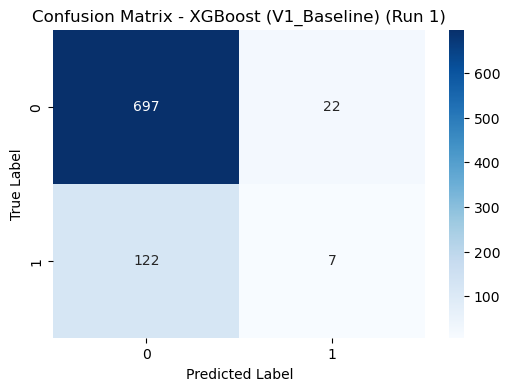

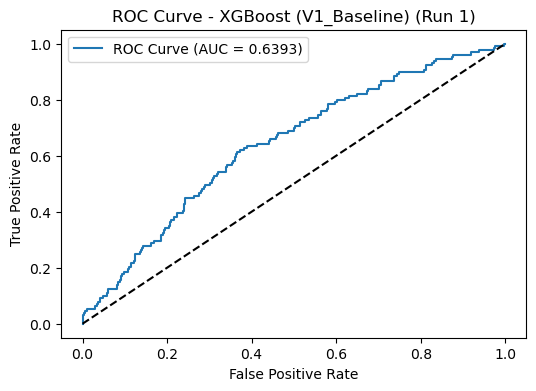

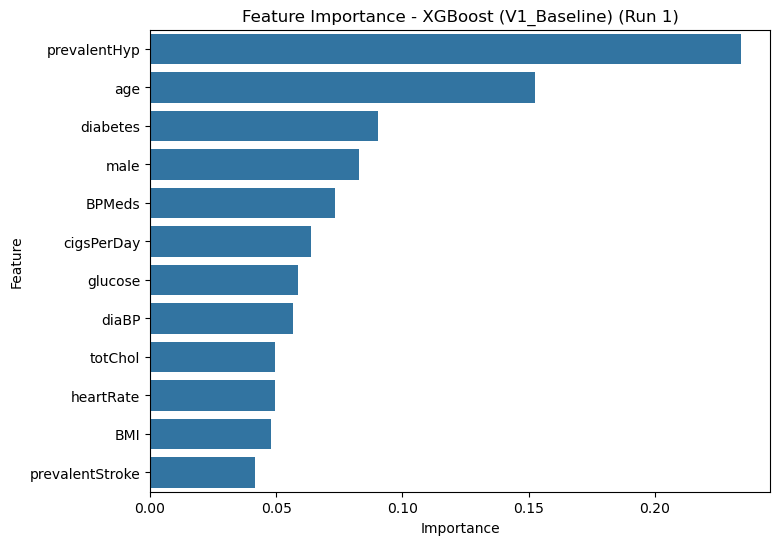


=== XGBoost - V2_Deeper_Slower ===

XGBoost (V2_Deeper_Slower) - Run 2
Accuracy: 0.8196
Precision: 0.2000
Recall: 0.0620
F1 Score: 0.0947
ROC AUC: 0.6169
Cross-Validation F1: 0.1644 ± 0.0205


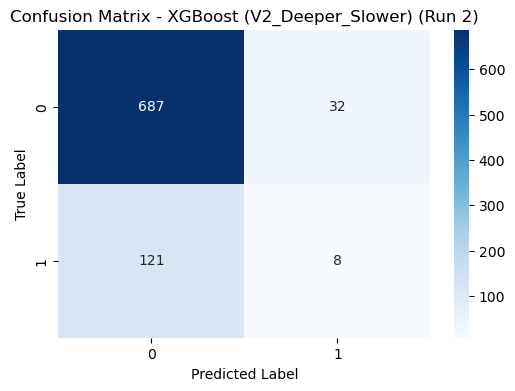

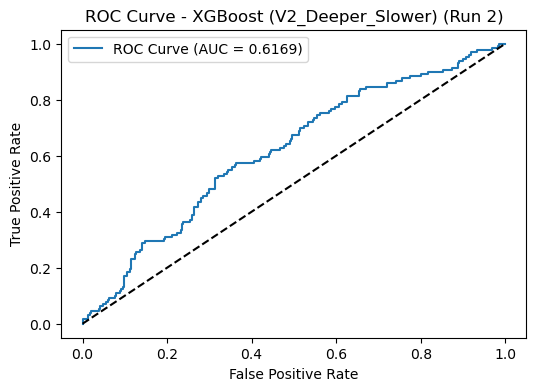

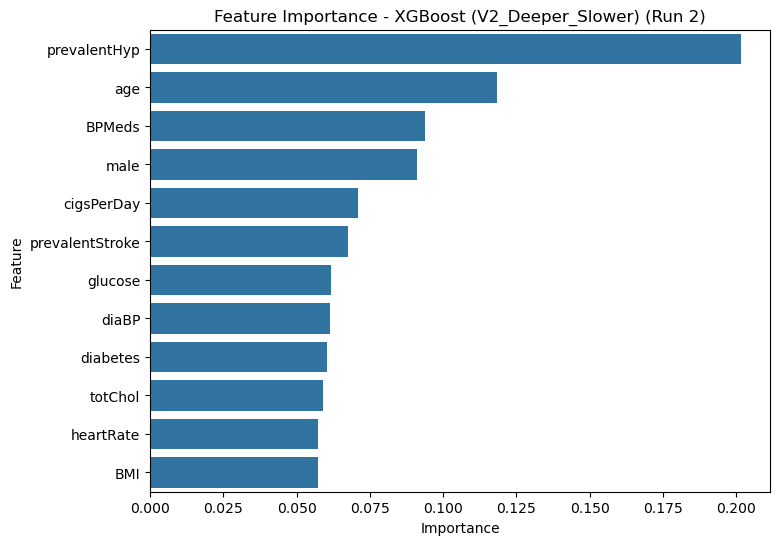


=== XGBoost - V3_Shallow_Faster ===

XGBoost (V3_Shallow_Faster) - Run 3
Accuracy: 0.8337
Precision: 0.2857
Recall: 0.0620
F1 Score: 0.1019
ROC AUC: 0.6458
Cross-Validation F1: 0.1857 ± 0.0367


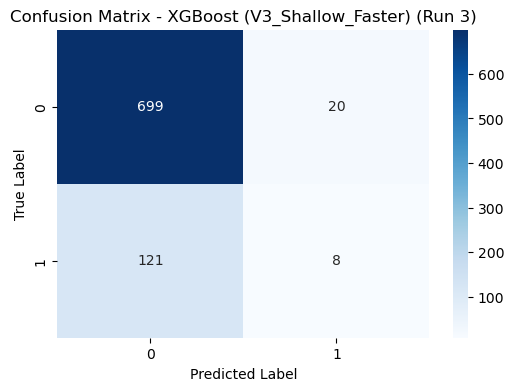

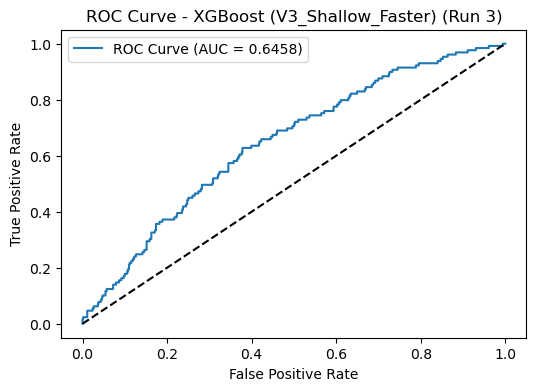

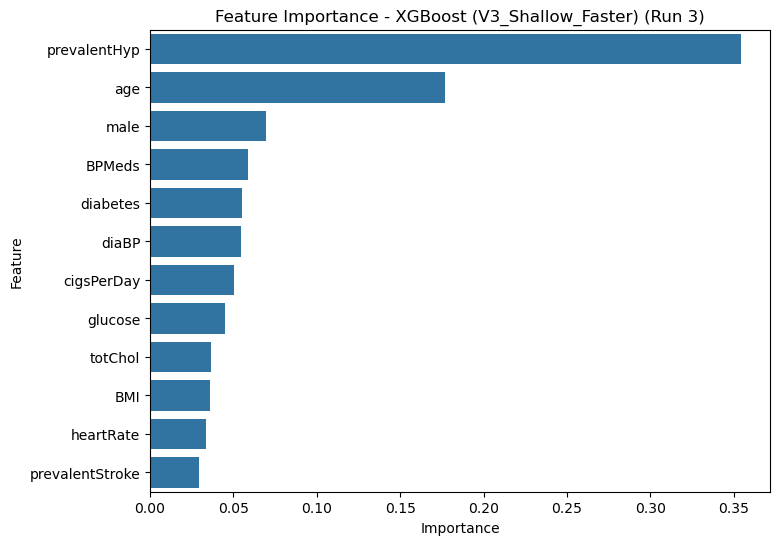


============================= XGBoost Summary =============================
             version  accuracy  precision    recall        f1   roc_auc  \
0        V1_Baseline  0.830189   0.241379  0.054264  0.088608  0.639260   
1   V2_Deeper_Slower  0.819575   0.200000  0.062016  0.094675  0.616867   
2  V3_Shallow_Faster  0.833726   0.285714  0.062016  0.101911  0.645788   

   cv_f1_mean  
0    0.161364  
1    0.164360  
2    0.185707  


In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

data_path = "newHeartDiseasedataset.csv" 

data = pd.read_csv(data_path)

# Define features and target 
X = data.drop('TenYearCHD', axis=1)
y = data['TenYearCHD']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Evaluation Function
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name, run_number):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Cross-validation (optional F1)
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

    # Print results
    print(f"\n{model_name} - Run {run_number}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Cross-Validation F1: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model_name} (Run {run_number})')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name} (Run {run_number})')
    plt.legend(loc='best')
    plt.show()

    # Feature Importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(8, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance)
    plt.title(f'Feature Importance - {model_name} (Run {run_number})')
    plt.show()

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'cv_f1_mean': cv_scores.mean()
    }

# XGBoost 
model_name = 'XGBoost'
results = []

# --- Variations ---
variations = {
    "V1_Baseline": {'n_estimators': 100, 'learning_rate': 0.1, 'max_depth': 5},
    "V2_Deeper_Slower": {'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 8},
    "V3_Shallow_Faster": {'n_estimators': 100, 'learning_rate': 0.2, 'max_depth': 3}
}

# Run all 3 versions
for i, (name, params) in enumerate(variations.items(), start=1):
    print(f"\n=== {model_name} - {name} ===")
    model = XGBClassifier(random_state=42, eval_metric='logloss', **params)
    result = evaluate_model(model, X_train, X_test, y_train, y_test, f"{model_name} ({name})", i)
    result['version'] = name
    results.append(result)

# Summarize Results
results_df = pd.DataFrame(results)
print(f"\n============================= {model_name} Summary =============================")
print(results_df[['version', 'accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'cv_f1_mean']])
